Final btc_all row count: 44
Date range: 2024-08-21 to 2024-11-20
                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     4.165
Date:                Fri, 21 Mar 2025   Prob (F-statistic):            0.00664
Time:                        16:43:21   Log-Likelihood:                 102.37
No. Observations:                  44   AIC:                            -194.7
Df Residuals:                      39   BIC:                            -185.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

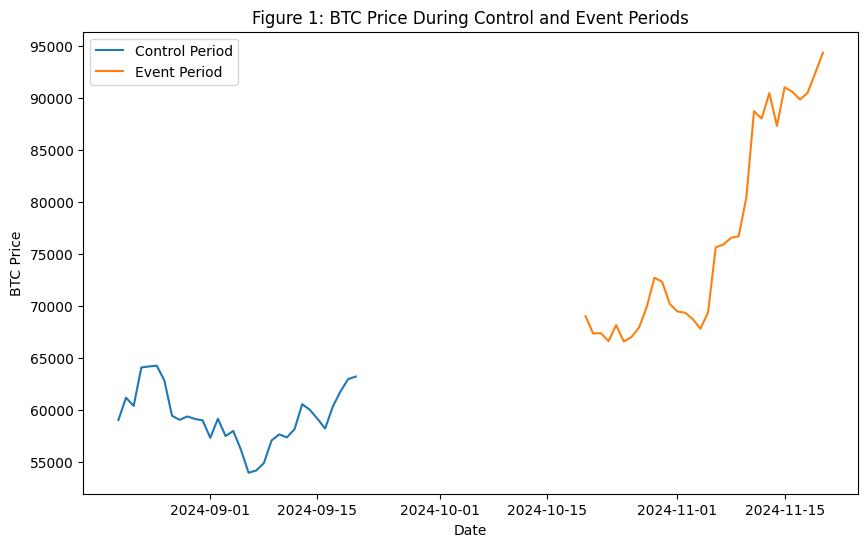

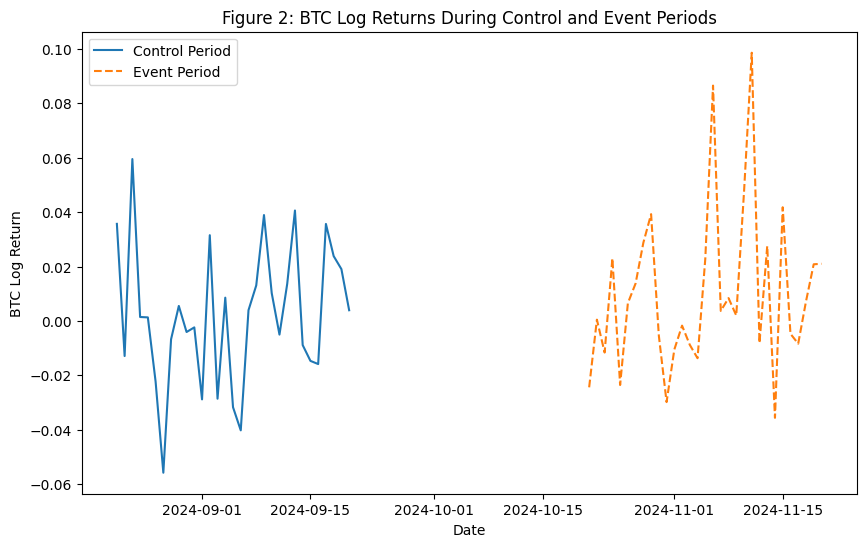

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

data_dir = "../data"

btc_ctrl = pd.read_csv(os.path.join(data_dir, 'btc_control_period_clean.csv'), parse_dates=['date'])
btc_evt = pd.read_csv(os.path.join(data_dir, 'btc_event_period_clean.csv'), parse_dates=['date'])

btc_ctrl['log_ret'] = np.log(btc_ctrl['close'] / btc_ctrl['close'].shift(1))
btc_evt['log_ret'] = np.log(btc_evt['close'] / btc_evt['close'].shift(1))

btc = pd.concat([btc_ctrl, btc_evt])
btc['event'] = btc['date'].apply(lambda x: 1 if x in btc_evt['date'].values else 0)

sp500_ctrl = pd.read_csv(os.path.join(data_dir, 'sp500_control_period_clean.csv'), parse_dates=['date'])
sp500_evt = pd.read_csv(os.path.join(data_dir, 'sp500_event_period_clean.csv'), parse_dates=['date'])
sp500 = pd.concat([sp500_ctrl, sp500_evt])
sp500.rename(columns={"close": "sp500_close"}, inplace=True)
sp500['sp500_ret'] = sp500['sp500_close'].pct_change()

vix_ctrl = pd.read_csv(os.path.join(data_dir, 'vix_control_period_clean.csv'), parse_dates=['date'])
vix_evt = pd.read_csv(os.path.join(data_dir, 'vix_event_period_clean.csv'), parse_dates=['date'])
vix = pd.concat([vix_ctrl, vix_evt])
vix.rename(columns={"close": "vix_close"}, inplace=True)
vix['vix_change'] = vix['vix_close'].pct_change()

treasury_ctrl = pd.read_csv(os.path.join(data_dir, 'treasury_yield_control_period_clean.csv'), parse_dates=['date'])
treasury_evt = pd.read_csv(os.path.join(data_dir, 'treasury_yield_event_period_clean.csv'), parse_dates=['date'])
treasury = pd.concat([treasury_ctrl, treasury_evt])
treasury['yield_diff'] = treasury['treasury_yield'].diff()

btc['date'] = btc['date'].dt.date
sp500['date'] = sp500['date'].dt.date
vix['date'] = vix['date'].dt.date
treasury['date'] = treasury['date'].dt.date

btc = btc.merge(sp500[['date', 'sp500_ret']], on='date', how='left')
btc = btc.merge(vix[['date', 'vix_change']], on='date', how='left')
btc = btc.merge(treasury[['date', 'yield_diff']], on='date', how='left')

btc.dropna(subset=['log_ret', 'sp500_ret', 'vix_change', 'yield_diff'], inplace=True)

btc_ctrl[['log_ret']].describe().T.to_csv("../tables/election_stats_control.csv")
btc_evt[['log_ret']].describe().T.to_csv("../tables/election_stats_event.csv")
btc[['log_ret', 'sp500_ret', 'vix_change', 'yield_diff']].describe().T.to_csv("../tables/election_stats_all.csv")

if btc.empty:
    raise ValueError("btc is empty after merging. Check date ranges.")

X = sm.add_constant(btc[['event', 'sp500_ret', 'vix_change', 'yield_diff']])
y = btc['log_ret']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

plt.figure(figsize=(10, 6))
plt.plot(btc_ctrl['date'], btc_ctrl['close'], label='Control')
plt.plot(btc_evt['date'], btc_evt['close'], label='Event')
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.title("BTC Price — Control vs. Event")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(btc_ctrl['date'], btc_ctrl['log_ret'], label='Control')
plt.plot(btc_evt['date'], btc_evt['log_ret'], label='Event', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.title("BTC Log Returns — Control vs. Event")
plt.legend()
plt.show()
